***1. Preprocessing_Location***

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [3]:
df = pd.read_csv('original data.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [4]:
df_cleaned = df.dropna()
print(f"Total records after cleaning: {len(df_cleaned)} ")

Total records after cleaning: 38502 


In [5]:
nyc_df = df_cleaned[df_cleaned['city'] == 'NYC']  
print(f"Total records in NYC dataset after filtering: {len(nyc_df)} ")

Total records in NYC dataset after filtering: 17856 


In [6]:
print(nyc_df.isnull().sum())
nyc_df.to_csv('cleaned_nyc_data.csv', index=False)
print("Cleaned data has been saved as 'cleaned_nyc_data.csv'")

id                        0
log_price                 0
property_type             0
room_type                 0
amenities                 0
accommodates              0
bathrooms                 0
bed_type                  0
cancellation_policy       0
cleaning_fee              0
city                      0
description               0
first_review              0
host_has_profile_pic      0
host_identity_verified    0
host_response_rate        0
host_since                0
instant_bookable          0
last_review               0
latitude                  0
longitude                 0
name                      0
neighbourhood             0
number_of_reviews         0
review_scores_rating      0
thumbnail_url             0
zipcode                   0
bedrooms                  0
beds                      0
dtype: int64
Cleaned data has been saved as 'cleaned_nyc_data.csv'


Location

1) import GeoJson File (downloaded from Github)

In [9]:
import geopandas as gpd
from shapely.geometry import Point

In [10]:
boroughs = gpd.read_file('boroughs.geojson')
print(boroughs.head())
df = pd.read_csv('cleaned_nyc_data.csv')
print(df.info())

   BoroCode       BoroName    Shape_Leng    Shape_Area  \
0         5  Staten Island  330385.03697  1.623853e+09   
1         4         Queens  861038.47930  3.049947e+09   
2         3       Brooklyn  726568.94634  1.959432e+09   
3         1      Manhattan  358532.95642  6.364422e+08   
4         2          Bronx  464517.89055  1.186804e+09   

                                            geometry  
0  MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...  
1  MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ...  
2  MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ...  
3  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...  
4  MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17856 entries, 0 to 17855
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      17856 non-null  int64  
 1   log_price               17856 non-null  float64


2) classify data into five boroughs (according to lat/lon)

In [12]:
def assign_borough(lat, lon, boroughs_gdf):
    point = Point(lon, lat)
    for _, borough in boroughs_gdf.iterrows():
        if borough['geometry'].contains(point):
            return borough['BoroName']  
    return "Other"  

In [13]:
nyc_df= df[df['city'] == 'NYC'].copy()
nyc_df['geometry'] = nyc_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
nyc_gdf = gpd.GeoDataFrame(nyc_df, geometry='geometry')

boroughs = boroughs.to_crs("EPSG:4326")  
nyc_gdf.set_crs("EPSG:4326", inplace=True) 

nyc_gdf = gpd.sjoin(nyc_gdf, boroughs, how='left', predicate='within')

nyc_gdf['borough'] = nyc_gdf['BoroName']

print(nyc_gdf['borough'].value_counts())

print(nyc_df['latitude'].min(), nyc_df['latitude'].max())
print(nyc_df['longitude'].min(), nyc_df['longitude'].max())


borough
Manhattan        8030
Brooklyn         7367
Queens           1946
Bronx             376
Staten Island     135
Name: count, dtype: int64
40.50868437 40.90389506
-74.23985905 -73.71737449


In [14]:
missing_boroughs = nyc_gdf[nyc_gdf['borough'].isnull()]
print(f"Number of rows with missing borough: {missing_boroughs.shape[0]}")
print(missing_boroughs.head())


Number of rows with missing borough: 2
            id  log_price property_type        room_type  \
7414   7826323   3.871201         House     Private room   
14933  4156913   5.703782         House  Entire home/apt   

                                               amenities  accommodates  \
7414   {"Wireless Internet",Kitchen,"Free parking on ...             2   
14933  {TV,"Wireless Internet","Air conditioning",Kit...             6   

       bathrooms  bed_type cancellation_policy  cleaning_fee  ... zipcode  \
7414         1.0  Real Bed            flexible         False  ...   10550   
14933        2.5  Real Bed            moderate          True  ...   11509   

      bedrooms beds                    geometry index_right BoroCode BoroName  \
7414       1.0  1.0  POINT (-73.83585 40.89809)         NaN      NaN      NaN   
14933      4.0  5.0  POINT (-73.73961 40.59057)         NaN      NaN      NaN   

      Shape_Leng Shape_Area  borough  
7414         NaN        NaN      NaN  
149

In [15]:
nyc_gdf = nyc_gdf.dropna(subset=['borough'])

In [16]:
nyc_gdf.drop(columns='geometry').to_csv('nyc_classified_data.csv', index=False)

print("Classified data has been successfully saved as 'nyc_classified_data.csv'")

Classified data has been successfully saved as 'nyc_classified_data.csv'


3)  plot

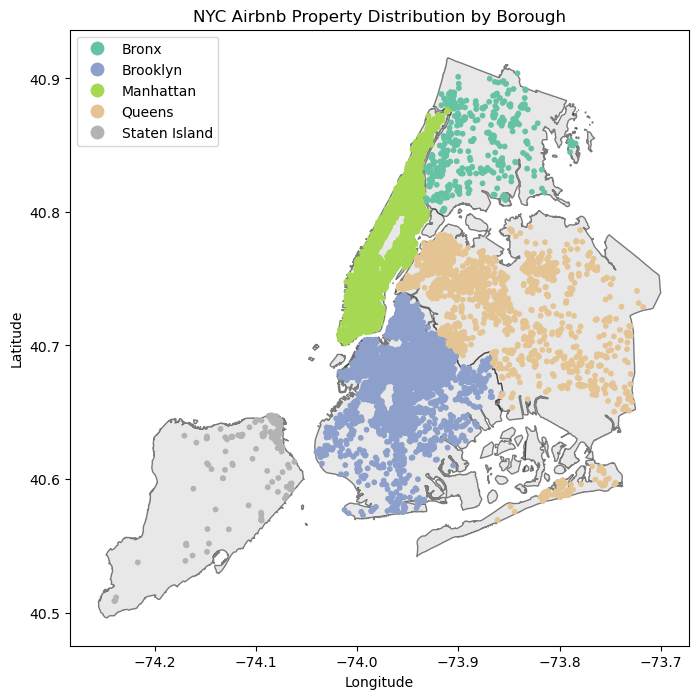

In [18]:
if not isinstance(nyc_gdf, gpd.GeoDataFrame):
    print("Please ensure the data is in GeoDataFrame format and contains the geometry column")
else:
    fig, ax = plt.subplots(figsize=(12, 8))
    boroughs.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)  
    nyc_gdf.plot(column='borough', ax=ax, markersize=10, legend=True, cmap='Set2') 
    plt.title("NYC Airbnb Property Distribution by Borough")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

Distance to Airport

In [20]:
nyc_df = pd.read_csv('nyc_classified_data.csv')
print(nyc_df.columns)


Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'index_right', 'BoroCode', 'BoroName', 'Shape_Leng', 'Shape_Area',
       'borough'],
      dtype='object')


C:\Users\sylvi\AppData\Local\Temp\ipykernel_8048\3986478363.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_df = pd.read_csv('nyc_classified_data.csv')


In [21]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

jfk_airport = (40.6413, -73.7781) 
lga_airport = (40.7769, -73.8740)  
ewr_airport = (40.6895, -74.1745)  

In [22]:
nyc_df['distance_to_jfk'] = nyc_df.apply(
    lambda row: haversine(row['latitude'], row['longitude'], jfk_airport[0], jfk_airport[1]),
    axis=1
)
nyc_df['distance_to_lga'] = nyc_df.apply(
    lambda row: haversine(row['latitude'], row['longitude'], lga_airport[0], lga_airport[1]),
    axis=1
)
nyc_df['distance_to_ewr'] = nyc_df.apply(
    lambda row: haversine(row['latitude'], row['longitude'], ewr_airport[0], ewr_airport[1]),
    axis=1
)
print(nyc_df[['id','distance_to_jfk', 'distance_to_lga', 'distance_to_ewr']].head())

         id  distance_to_jfk  distance_to_lga  distance_to_ewr
0   6304928        22.556586         9.761466        17.799104
1   7919400        23.214594         6.821102        23.489703
2   5578513        19.631988        10.973902        16.516343
3  18224863        14.578484        16.158419        19.536180
4  16679342        12.307846        14.025187        21.558997


In [23]:
nyc_df.to_csv('nyc_with_distances.csv', index=False)
print("Computation completed, data saved as 'nyc_with_distances.csv'")

Computation completed, data saved as 'nyc_with_distances.csv'


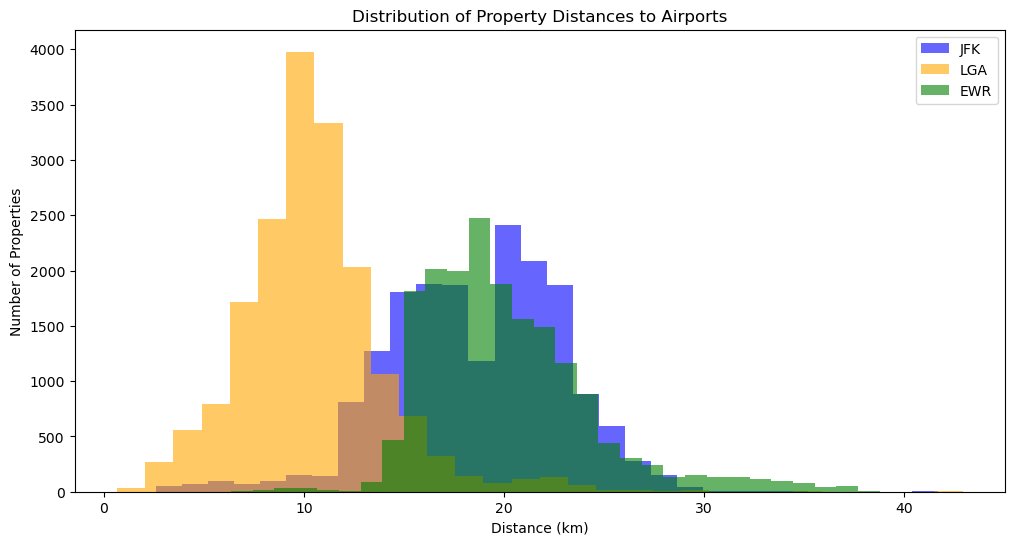

In [24]:
plt.figure(figsize=(12, 6))

plt.hist(nyc_df['distance_to_jfk'], bins=30, alpha=0.6, label='JFK', color='blue')
plt.hist(nyc_df['distance_to_lga'], bins=30, alpha=0.6, label='LGA', color='orange')
plt.hist(nyc_df['distance_to_ewr'], bins=30, alpha=0.6, label='EWR', color='green')

plt.title("Distribution of Property Distances to Airports")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()


Distance to tourist attractions

In [26]:
nyc_df = pd.read_csv('nyc_with_distances.csv')
print(nyc_df.columns)

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'index_right', 'BoroCode', 'BoroName', 'Shape_Leng', 'Shape_Area',
       'borough', 'distance_to_jfk', 'distance_to_lga', 'distance_to_ewr'],
      dtype='object')


C:\Users\sylvi\AppData\Local\Temp\ipykernel_8048\2791484958.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_df = pd.read_csv('nyc_with_distances.csv')


1) Bronx

In [28]:
bronx_df = nyc_df[nyc_df['borough'] == 'Bronx'].copy()

In [29]:
bronx_landmarks = {
    "New York Botanical Garden": (40.8617, -73.8801),
    "Bronx Zoo": (40.8506, -73.8763),
    "Yankee Stadium": (40.8296, -73.9262)
}

In [30]:
prefix = 'bronx'

for landmark, coords in bronx_landmarks.items():
    bronx_df[f'{prefix}_{landmark.replace(" ", "_").lower()}_distance'] = bronx_df.apply(
        lambda row: haversine(row['latitude'], row['longitude'], coords[0], coords[1]),
        axis=1
    )

print(bronx_df[[col for col in bronx_df.columns if f'{prefix}_' in col]].head())


     bronx_new_york_botanical_garden_distance  bronx_bronx_zoo_distance  \
38                                   6.286574                  5.021895   
114                                  4.281037                  4.769779   
135                                  5.635136                  4.746414   
178                                  3.315623                  4.357397   
199                                  5.319659                  4.455665   

     bronx_yankee_stadium_distance  
38                        6.551017  
114                       9.488413  
135                       2.014750  
178                       8.452701  
199                       1.825599  


In [31]:
new_columns = ['bronx_new_york_botanical_garden_distance', 
               'bronx_bronx_zoo_distance', 
               'bronx_yankee_stadium_distance']

print(bronx_df[new_columns].head())

for col in new_columns:
    nyc_df.loc[nyc_df['borough'] == 'Bronx', col] = bronx_df[col]


output_path = 'nyc_with_distances.csv'
nyc_df.to_csv(os.path.expanduser(output_path), index=False)

print(f"The new columns have been successfully added and saved to {output_path}")


     bronx_new_york_botanical_garden_distance  bronx_bronx_zoo_distance  \
38                                   6.286574                  5.021895   
114                                  4.281037                  4.769779   
135                                  5.635136                  4.746414   
178                                  3.315623                  4.357397   
199                                  5.319659                  4.455665   

     bronx_yankee_stadium_distance  
38                        6.551017  
114                       9.488413  
135                       2.014750  
178                       8.452701  
199                       1.825599  
The new columns have been successfully added and saved to nyc_with_distances.csv


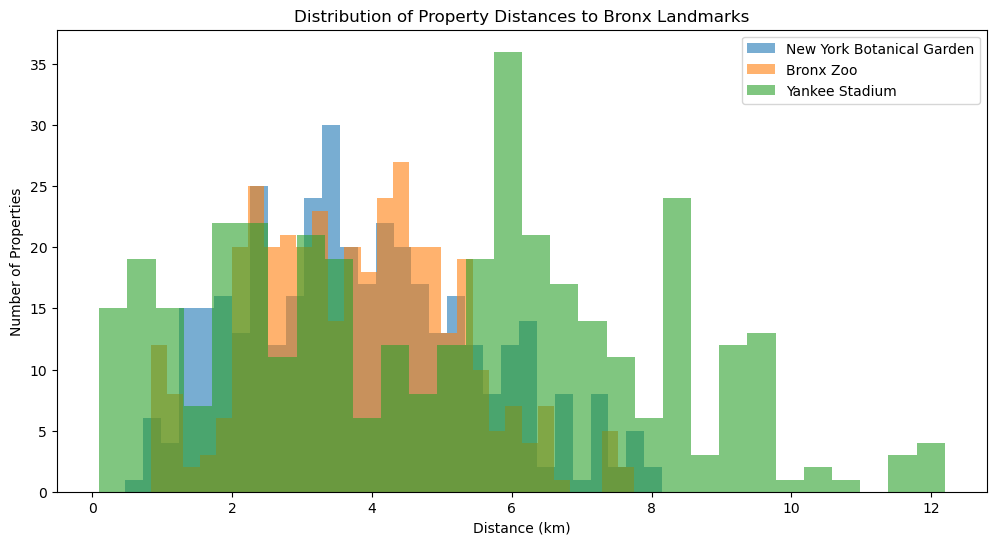

In [32]:
plt.figure(figsize=(12, 6))
for landmark in bronx_landmarks.keys():
    column_name = f'bronx_{landmark.replace(" ", "_").lower()}_distance'  
    plt.hist(bronx_df[column_name], bins=30, alpha=0.6, label=landmark)
    
plt.title("Distribution of Property Distances to Bronx Landmarks")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()


2) Brooklyn

In [34]:
brooklyn_df = nyc_df[nyc_df['borough'] == 'Brooklyn'].copy()

In [35]:
brooklyn_landmarks = {
    "Brooklyn Bridge": (40.7061, -73.9969),
    "Brooklyn Museum": (40.6712, -73.9636),
    "Prospect Park": (40.6602, -73.9690),
}

In [36]:
prefix = 'brooklyn'
for landmark, coords in brooklyn_landmarks.items():
    column_name = f'{prefix}_{landmark.replace(" ", "_").lower()}_distance'
    brooklyn_df[column_name] = brooklyn_df.apply(
        lambda row: haversine(row['latitude'], row['longitude'], coords[0], coords[1]),
        axis=1
    )
print(brooklyn_df[[col for col in brooklyn_df.columns if f'{prefix}_' in col]].head())

    brooklyn_brooklyn_bridge_distance  brooklyn_brooklyn_museum_distance  \
3                            7.944195                           3.233742   
4                            8.360470                           3.832219   
8                            6.437757                           1.678598   
9                            8.753014                           4.429630   
10                           4.473129                           5.130823   

    brooklyn_prospect_park_distance  
3                          2.383247  
4                          3.934416  
8                          1.718880  
9                          4.681652  
10                         6.434742  


In [37]:
new_columns = ['brooklyn_brooklyn_bridge_distance', 
               'brooklyn_brooklyn_museum_distance', 
               'brooklyn_prospect_park_distance']

for col in new_columns:
    nyc_df.loc[nyc_df['borough'] == 'Brooklyn', col] = brooklyn_df[col]


output_path = 'nyc_with_distances.csv'
nyc_df.to_csv(os.path.expanduser(output_path), index=False)

print(f"The new columns have been successfully added and saved to {output_path}")


The new columns have been successfully added and saved to nyc_with_distances.csv


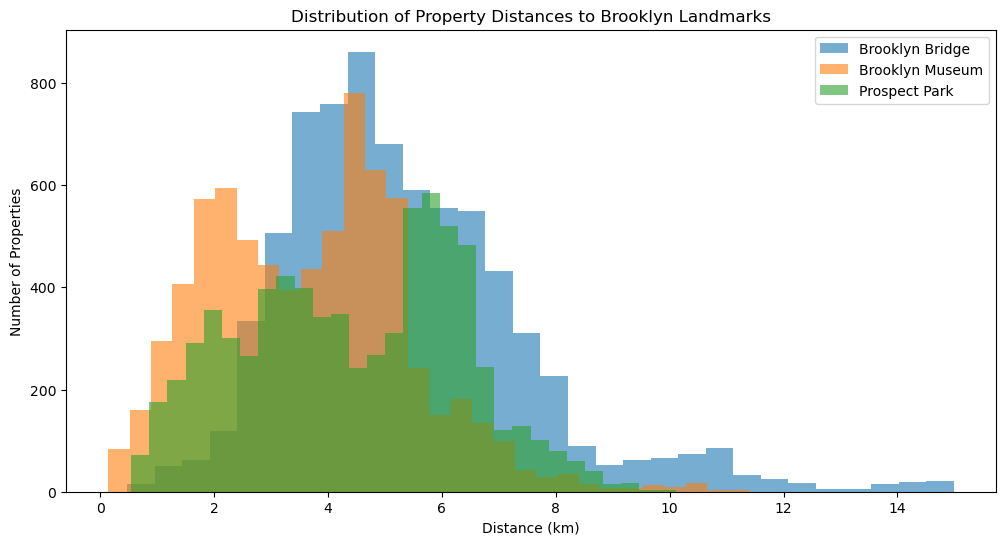

In [38]:
plt.figure(figsize=(12, 6))
for landmark in brooklyn_landmarks.keys():
    column_name = f'{prefix}_{landmark.replace(" ", "_").lower()}_distance'
    plt.hist(brooklyn_df[column_name], bins=30, alpha=0.6, label=landmark)

plt.title("Distribution of Property Distances to Brooklyn Landmarks")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

3) Manhattan

In [40]:
manhattan_df = nyc_df[nyc_df['borough'] == 'Manhattan'].copy()

In [41]:
manhattan_landmarks = {
    "Times Square": (40.7580, -73.9855),
    "Central Park": (40.7851, -73.9683),
    "Empire State Building": (40.7488, -73.9854),
    "Wall Street": (40.7074, -74.0113),
    "The Met": (40.7794, -73.9632)
}

In [42]:
prefix = 'manhattan'
for landmark, coords in manhattan_landmarks.items():
    column_name = f'{prefix}_{landmark.replace(" ", "_").lower()}_distance'
    manhattan_df[column_name] = manhattan_df.apply(
        lambda row: haversine(row['latitude'], row['longitude'], coords[0], coords[1]),
        axis=1
    )

print(manhattan_df[[col for col in manhattan_df.columns if f'{prefix}_' in col]].head())

    manhattan_times_square_distance  manhattan_central_park_distance  \
0                          0.950369                         2.739744   
1                          6.587855                         3.288634   
2                          3.796060                         6.932345   
7                          0.936819                         4.004979   
13                         2.853119                         6.192325   

    manhattan_empire_state_building_distance  manhattan_wall_street_distance  \
0                                   1.949643                        6.792900   
1                                   7.469212                       12.560679   
2                                   2.773571                        2.949548   
7                                   0.422174                        5.422775   
13                                  1.941820                        3.178777   

    manhattan_the_met_distance  
0                     2.629977  
1                   

In [43]:
new_columns = ['manhattan_times_square_distance', 
               'manhattan_central_park_distance', 
               'manhattan_empire_state_building_distance',
              'manhattan_wall_street_distance',
              'manhattan_the_met_distance']

for col in new_columns:
    nyc_df.loc[nyc_df['borough'] == 'Manhattan', col] = manhattan_df[col]


output_path = 'nyc_with_distances.csv'
nyc_df.to_csv(os.path.expanduser(output_path), index=False)

print(f"The new columns have been successfully added and saved to {output_path}")


The new columns have been successfully added and saved to nyc_with_distances.csv


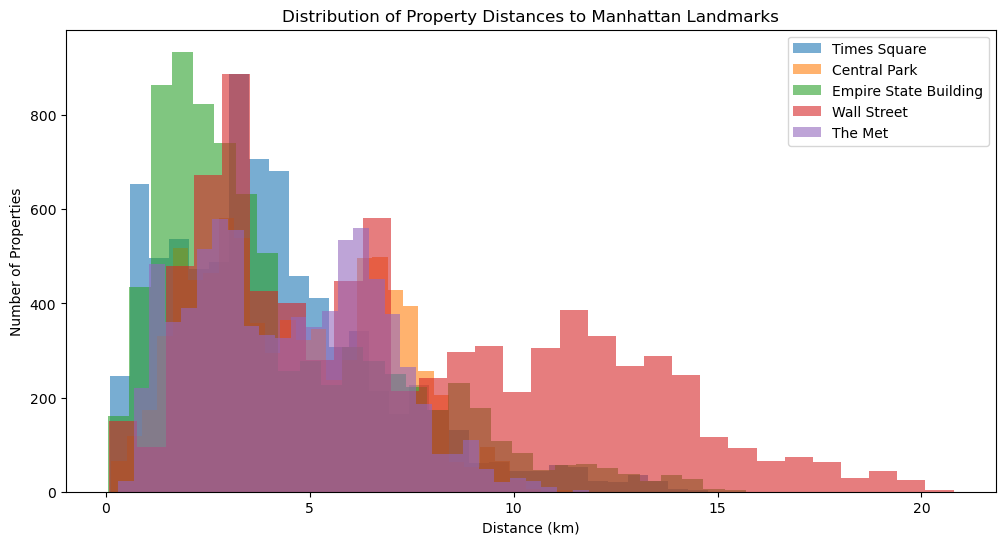

In [44]:
plt.figure(figsize=(12, 6))
for landmark in manhattan_landmarks.keys():
    column_name = f'{prefix}_{landmark.replace(" ", "_").lower()}_distance'
    plt.hist(manhattan_df[column_name], bins=30, alpha=0.6, label=landmark)

plt.title("Distribution of Property Distances to Manhattan Landmarks")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()

4) Queens

In [46]:
queens_df = nyc_df[nyc_df['borough'] == 'Queens'].copy()

In [47]:
queens_landmarks = {
    "Flushing Meadows Corona Park": (40.7498, -73.8401),  
    "Museum of the Moving Image": (40.7563, -73.9235),  
    "Queens Botanical Garden": (40.7516, -73.8276)  
}

In [48]:
prefix = 'queens'
for landmark, coords in queens_landmarks.items():
    column_name = f'{prefix}_{landmark.replace(" ", "_").lower()}_distance'
    queens_df[column_name] = queens_df.apply(
        lambda row: haversine(row['latitude'], row['longitude'], coords[0], coords[1]),
        axis=1
    )

print(queens_df[[col for col in queens_df.columns if f'{prefix}_' in col]].head())

    queens_flushing_meadows_corona_park_distance  \
5                                      10.238762   
6                                       2.388706   
30                                      2.507286   
66                                      7.079696   
68                                     18.154708   

    queens_museum_of_the_moving_image_distance  \
5                                    16.616944   
6                                     6.723704   
30                                    9.367813   
66                                    4.725221   
68                                   21.486637   

    queens_queens_botanical_garden_distance  
5                                  9.578515  
6                                  3.124137  
30                                 1.464671  
66                                 8.081144  
68                                18.148362  


In [49]:
new_columns = ['queens_flushing_meadows_corona_park_distance', 
               'queens_museum_of_the_moving_image_distance', 
               'queens_queens_botanical_garden_distance']

for col in new_columns:
    nyc_df.loc[nyc_df['borough'] == 'Queens', col] = queens_df[col]


output_path = 'nyc_with_distances.csv'
nyc_df.to_csv(os.path.expanduser(output_path), index=False)

print(f"The new columns have been successfully added and saved to {output_path}")


The new columns have been successfully added and saved to nyc_with_distances.csv


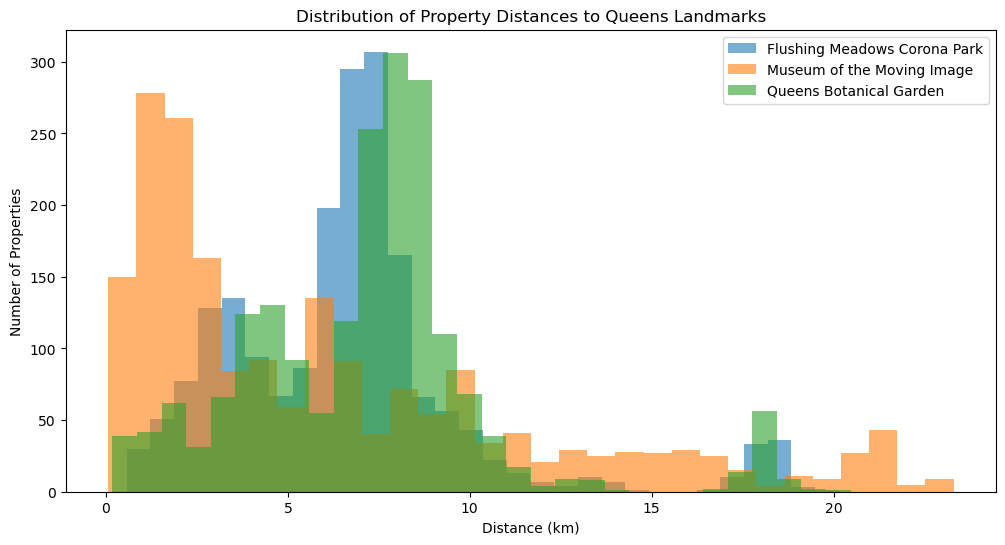

In [50]:
plt.figure(figsize=(12, 6))
for landmark in queens_landmarks.keys():
    column_name = f'{prefix}_{landmark.replace(" ", "_").lower()}_distance'
    plt.hist(queens_df[column_name], bins=30, alpha=0.6, label=landmark)

plt.title("Distribution of Property Distances to Queens Landmarks")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()


5) Staten Island

In [52]:
staten_island_df = nyc_df[nyc_df['borough'] == 'Staten Island'].copy()

In [53]:
staten_island_landmarks = {
    "Staten Island Ferry Terminal": (40.6437, -74.0732),  
    "Staten Island Zoo": (40.6251, -74.1170),  
    "Historic Richmond Town": (40.5696, -74.1455),  
    "National Lighthouse Museum": (40.6439, -74.0718),  
    "Staten Island Greenbelt Conservancy": (40.5795, -74.1452)
}

In [54]:
prefix = 'staten_island'
for landmark, coords in staten_island_landmarks.items():
    column_name = f'{prefix}_{landmark.replace(" ", "_").lower()}_distance'
    staten_island_df[column_name] = staten_island_df.apply(
        lambda row: haversine(row['latitude'], row['longitude'], coords[0], coords[1]),
        axis=1
    )

print(staten_island_df[[col for col in staten_island_df.columns if f'{prefix}_' in col]].head())

     staten_island_staten_island_ferry_terminal_distance  \
177                                           5.585215     
224                                           0.863594     
226                                           1.870417     
336                                          10.114065     
359                                           4.422318     

     staten_island_staten_island_zoo_distance  \
177                                  1.703506   
224                                  3.470383   
226                                  3.145357   
336                                  7.028271   
359                                  0.897007   

     staten_island_historic_richmond_town_distance  \
177                                       4.928042   
224                                       9.709676   
226                                       8.507243   
336                                       1.779959   
359                                       7.155613   

     staten_island_

In [55]:
new_columns = ['staten_island_staten_island_ferry_terminal_distance', 
               'staten_island_staten_island_zoo_distance', 
               'staten_island_historic_richmond_town_distance',
              'staten_island_national_lighthouse_museum_distance',
              'staten_island_staten_island_greenbelt_conservancy_distance']

for col in new_columns:
    nyc_df.loc[nyc_df['borough'] == 'Staten Island', col] = staten_island_df[col]


output_path = 'nyc_with_distances.csv'
nyc_df.to_csv(os.path.expanduser(output_path), index=False)

print(f"The new columns have been successfully added and saved to {output_path}")


The new columns have been successfully added and saved to nyc_with_distances.csv


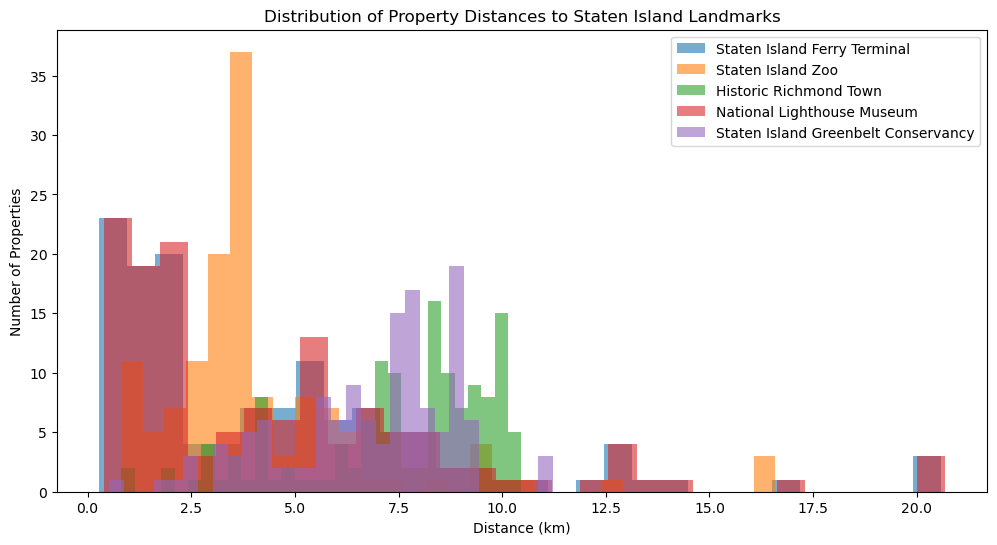

In [56]:
plt.figure(figsize=(12, 6))
for landmark in staten_island_landmarks.keys():
    column_name = f'{prefix}_{landmark.replace(" ", "_").lower()}_distance'
    plt.hist(staten_island_df[column_name], bins=30, alpha=0.6, label=landmark)

plt.title("Distribution of Property Distances to Staten Island Landmarks")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Properties")
plt.legend()
plt.show()


plot

In [58]:
airports = {
    "JFK Airport": (40.6413, -73.7781) ,
    "LaGuardia Airport": (40.7769, -73.8740) ,
    "Newark Airport": (40.6895, -74.1745)
}

landmarks = {
    "Bronx": {
         "New York Botanical Garden": (40.8617, -73.8801),
         "Bronx Zoo": (40.8506, -73.8763),
         "Yankee Stadium": (40.8296, -73.9262)
    },
    "Brooklyn": {
          "Brooklyn Bridge": (40.7061, -73.9969),
          "Brooklyn Museum": (40.6712, -73.9636),
          "Prospect Park": (40.6602, -73.9690),
    },
    "Manhattan": {
        "Times Square": (40.7580, -73.9855),
        "Central Park": (40.7851, -73.9683),
        "Empire State Building": (40.7488, -73.9854),
        "Wall Street": (40.7074, -74.0113),
        "The Met": (40.7794, -73.9632)
    },
    "Queens": {
         "Flushing Meadows Corona Park": (40.7498, -73.8401),  
         "Museum of the Moving Image": (40.7563, -73.9235),  
         "Queens Botanical Garden": (40.7516, -73.8276)
    },
    "Staten Island":{
        "Staten Island Ferry Terminal": (40.6437, -74.0732),  
        "Staten Island Zoo": (40.6251, -74.1170),  
        "Historic Richmond Town": (40.5696, -74.1455),  
        "National Lighthouse Museum": (40.6439, -74.0718),  
        "Staten Island Greenbelt Conservancy": (40.5795, -74.1452)
    }
}

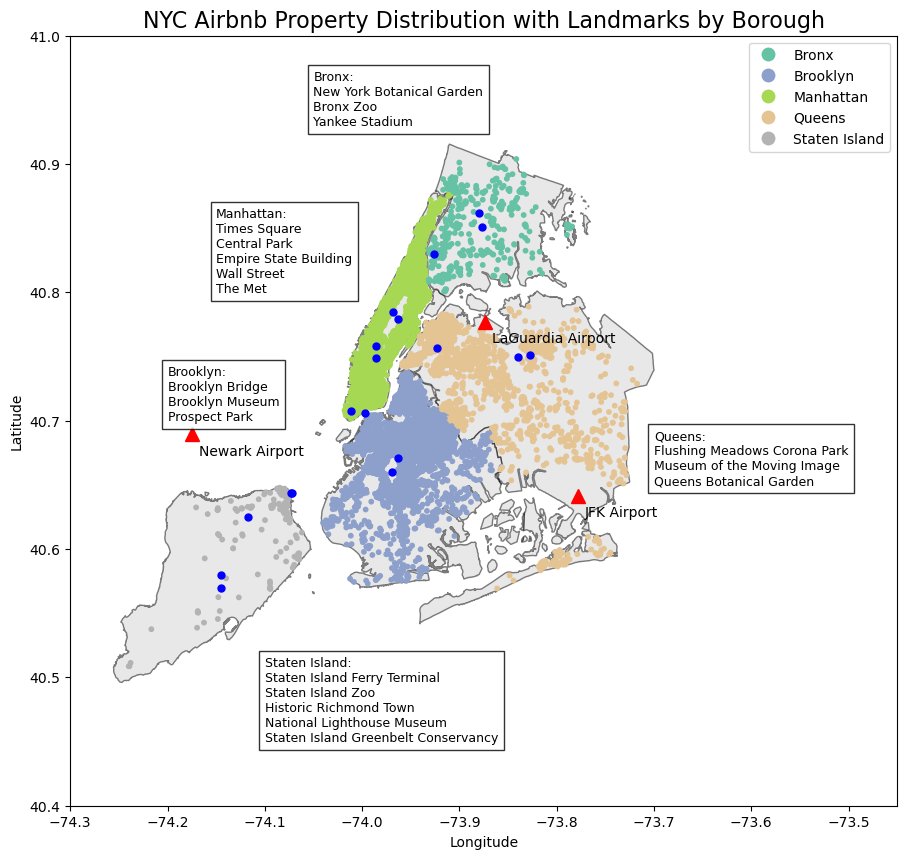

In [59]:
fig, ax = plt.subplots(figsize=(12, 10))

boroughs.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)  
nyc_gdf.plot(column='borough', ax=ax, markersize=10, legend=True, cmap='Set2') 

labels = {
    "Bronx": (-74.05, 40.93),
    "Brooklyn": (-74.20, 40.70),
    "Manhattan": (-74.15, 40.80),
    "Queens": (-73.70, 40.65),
    "Staten Island": (-74.1, 40.45)
}
for borough, points in landmarks.items():
    for name, coord in points.items():
        ax.plot(
            coord[1], coord[0],  
            marker='o', color='blue', markersize=5, label=name if ax.get_legend() is None else ""
        )
for airport, coord in airports.items():
    ax.plot(
        coord[1], coord[0],  
        marker='^', color='red', markersize=10, label=airport if ax.get_legend() is None else ""
    )
    ax.annotate(
    airport,
    xy=(coord[1], coord[0]),  
    xytext=(5, -15), 
    textcoords='offset points',
    fontsize=10,
    color='black'
    )    

for borough, points in landmarks.items():
    landmark_list = "\n".join(points.keys())
    ax.annotate(
        f"{borough}:\n{landmark_list}",
        xy=labels[borough],  
        xytext=(0, 0),       
        textcoords="offset points",
        fontsize=9,
        color="black",
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
    )

plt.title("NYC Airbnb Property Distribution with Landmarks by Borough", fontsize=16)
plt.xlim([-74.3, -73.45])
plt.ylim([40.4, 41.0])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



Distance to the Center of Manhattan

In [61]:
nyc_df = pd.read_csv('nyc_with_distances.csv')
print(nyc_df.columns)

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'index_right', 'BoroCode', 'BoroName', 'Shape_Leng', 'Shape_Area',
       'borough', 'distance_to_jfk', 'distance_to_lga', 'distance_to_ewr',
       'bronx_new_york_botanical_garden_distance', 'bronx_bronx_zoo_distance',
       'bronx_yankee_stadium_distance', 'brooklyn_brooklyn_bridge_distance',
       'brooklyn_brooklyn_museum_distance', 'brooklyn_prospect_park_distance',
       'manhattan_times_square_distance', 'manhattan_central_park_distance',
       'manhattan_empire_state_building_dista

C:\Users\sylvi\AppData\Local\Temp\ipykernel_8048\2791484958.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_df = pd.read_csv('nyc_with_distances.csv')


In [62]:
manhattan_center = (40.7831, -73.9712)  # Central Park

nyc_df['distance_to_manhattan'] = nyc_df.apply(
    lambda row: haversine(row['latitude'], row['longitude'], manhattan_center[0], manhattan_center[1]),
    axis=1
)

print(nyc_df[['borough', 'distance_to_manhattan']].head())

     borough  distance_to_manhattan
0  Manhattan               2.413194
1  Manhattan               3.615394
2  Manhattan               6.670668
3   Brooklyn              15.587109
4   Brooklyn              14.683675


In [63]:
output_path = 'nyc_with_distances.csv'

nyc_df.to_csv(output_path, index=False)

print(f"Data has been successfully saved to {output_path}")


Data has been successfully saved to nyc_with_distances.csv
